In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [39]:
weather_event_cat = {
    'inconnu': 1, 'pluie faible': 2, 'ciel clair': 3, 'brouillard faible': 4, 'pluie': 5, 'brouillard': 6,
    'neige faible': 7, 'pluie forte': 8, 'neige': 9, 'brouillard fort': 10
}

atmo_cat = {'bon': 1, 'moyen': 2, 'dégradé': 3, 'mauvais': 4}

wind_dir_cat = {
    'SO': 1, 'O': 2, 'SSO': 3, 'N': 4, 'S': 5, 'NE': 6, 'OSO': 7, 'NNO': 8, 'ONO': 9, 'ENE': 10, 'E': 11,
    'NNE': 12, 'NO': 13, 'SSE': 14, 'SE': 15, 'ESE': 16
}

In [73]:
df = pd.read_csv("./data/final/merged-final.csv", sep=';').dropna().drop("day", axis=1)
df["wind_dir_cat"] = df.wind_dir.apply(lambda x: wind_dir_cat[x])
df["weather_event_cat"] = df.weather_event.apply(lambda x: weather_event_cat[x])
df["atmo_cat"] = df.ATMO.apply(lambda x: atmo_cat[x])
df = df.drop(["ATMO", "weather_event", "wind_dir"], axis=1)

# Décalage d'une heure pour prédire l'indice atmo de l'heure suivante
atmo_values = df.atmo_cat.tolist()
atmo_values.insert(0, 0)
atmo_values.pop()
len(atmo_values), len(df.atmo_cat.tolist())
df.atmo_cat = atmo_values
df = df.drop(0)
df

1

(25611, 25611)

,date,PM10,PM25,NO2,SO2,NO,NOX,O3,temp,wind_speed,hum,press,wind_dir_cat,weather_event_cat,atmo_cat
1,2019-01-01 02:00:00,5.4,10.3,19.7,2.3,1.4,21.9,39.8,7.9,3.7,90.0,1036.2,8,1,1
2,2019-01-01 03:00:00,8.6,12.9,24.3,2.1,0.7,25.4,32.8,7.7,3.7,88.0,1035.8,2,1,1
3,2019-01-01 04:00:00,10.2,12.5,25.4,2.6,1.0,27.0,36.6,7.9,3.7,82.0,1035.4,9,1,1
4,2019-01-01 05:00:00,11.1,6.9,18.2,3.1,0.6,19.2,48.9,8.0,3.7,81.0,1034.8,2,1,1
5,2019-01-01 06:00:00,10.7,6.1,26.3,3.2,1.6,28.8,34.8,8.3,3.7,80.0,1034.9,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26271,2021-12-30 17:00:00,11.4,8.1,23.9,0.9,1.5,26.2,25.2,13.9,14.8,87.0,1022.3,1,3,1
26272,2021-12-30 18:00:00,10.8,7.5,27.7,0.6,2.3,31.2,20.9,14.0,14.8,87.0,1022.7,3,3,1
26273,2021-12-30 19:00:00,11.9,8.4,25.8,0.6,1.1,27.6,21.2,13.4,13.0,88.0,1022.8,3,3,1
26274,2021-12-30 20:00:00,11.8,8.8,31.1,0.6,1.1,32.9,14.2,12.5,11.1,91.0,1022.9,3,3,1


# Training

In [112]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' feature importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [74]:
y = df["atmo_cat"]
X = df.drop(["date", "atmo_cat"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
param_grid = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [6, 12, 24],
    "criterion": ["entropy", "gini"],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 4, 6]
}
 
rf = RandomForestClassifier()

gcv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid
)

In [120]:
gcv.fit(X_train, y_train)

/Users/thibaultrichel/Desktop/JupyterLab/jptlab_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [6, 12, 24],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [100, 200, 300, 400]})

In [125]:
best_params = gcv.best_params_
rf = RandomForestClassifier(**best_params)

In [126]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=24, min_samples_split=8,
                       n_estimators=200)

In [127]:
y_pred = rf.predict(X_test)

In [128]:
acc = accuracy_score(y_pred, y_test)
#f1 = f1_score(y_pred, y_test)

acc

0.8723155017571261

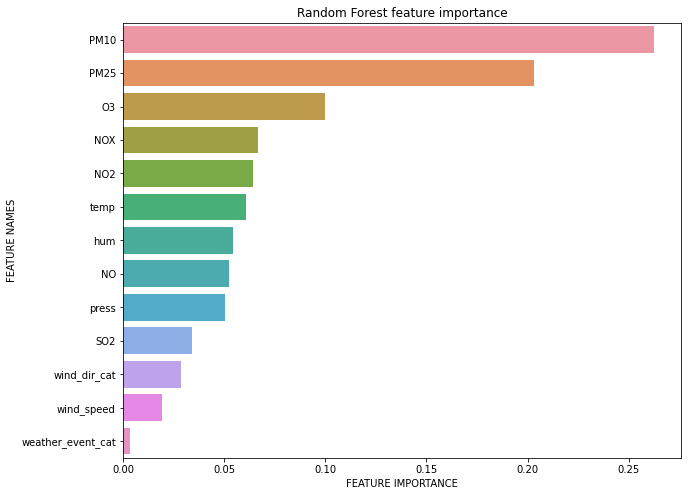

In [129]:
plot_feature_importance(rf.feature_importances_, X_train.columns, "Random Forest")